In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.model_selection import train_test_split
#print("Tensorflow version: "+ tf.__version__)

2022-12-04 23:20:24.471764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 23:20:24.630551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/agapo/colcon_coppelia_ws/install/image_transport/lib:/home/agapo/colcon_coppelia_ws/install/camera_info_manager/lib:/home/agapo/colcon_coppelia_ws/install/camera_calibration_parsers/lib:/home/agapo/catkin_coppelia_ws/install/image_transport/lib:/home/agapo/catkin_coppelia_ws/install/camera_info_manager/lib:/home/agapo/catkin_coppelia_ws/install/camera_calibration_parsers/lib:/usr/lib/x86_

In [3]:
# Google file system
COLAB=False
if COLAB==True:
    from google.colab import drive
    drive.mount('/GoogleDrive', force_remount=True)

ATT_FILE =   "datasets/FootballPlayerPreparedCleanAttributes.csv"
LABEL_FILE = "datasets/FootballPlayerOneHotEncodedClasses.csv"

attributes = pd.read_csv(ATT_FILE)
label =      pd.read_csv(LABEL_FILE)

## Datasets

In [7]:
attributes.shape

(16122, 17)

In [8]:
TRAIN_RATE = 0.8

n_instances = attributes.shape[0]

n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2)
n_final_test = n_instances-n_train-n_dev

In [9]:
print("Total:", n_instances, "| Train:", n_train, "| Dev Test:", n_dev," | Final Test:", n_final_test)

Total: 16122 | Train: 12897 | Dev Test: 1612  | Final Test: 1613


In [10]:
x_train, X_test, t_train, y_test = train_test_split(attributes,label,
                                                    test_size=0.2,
                                                    random_state=1992,
                                                    stratify=label)

x_final_test, x_dev, t_final_test, t_dev = train_test_split(X_test,y_test,
                                            test_size=0.5,
                                            random_state=1992)
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]

In [11]:
print ("X_train:", x_train.shape, "| T_train:", t_train.shape)
print ("X_dev:", x_dev.shape, "| T_dev:", t_dev.shape)
print ("X_test:", x_final_test.shape, "| T_test:", t_final_test.shape)

X_train: (12897, 17) | T_train: (12897, 4)
X_dev: (1613, 17) | T_dev: (1613, 4)
X_test: (1612, 17) | T_test: (1612, 4)


## Model

In [12]:
n_neurons_per_layer = [500, 250, 75, 25]
learning_rate = 0.1
n_epochs = 500
batch_size = 512

In [13]:
model = keras.Sequential(name = "FifaNetwork")

2022-12-04 23:24:52.832017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 23:24:52.832468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/agapo/colcon_coppelia_ws/install/image_transport/lib:/home/agapo/colcon_coppelia_ws/install/camera_info_manager/lib:/home/agapo/colcon_coppelia_ws/install/camera_calibration_parsers/lib:/home/agapo/catkin_coppelia_ws/install/image_transport/lib:/home/agapo/catkin_coppelia_ws/install/camera_info_manager/lib:/home/agapo/catkin_coppelia_ws/install/camera_calibration_parsers/lib:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/

In [15]:
model.add(keras.layers.InputLayer(input_shape=(INPUTS,)))

for neurons in n_neurons_per_layer:
  model.add(keras.layers.Dense(neurons, activation="relu"))

model.add(keras.layers.Dense(OUTPUTS, activation="softmax"))

In [16]:
model.summary()

Model: "FifaNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               9000      
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dense_2 (Dense)             (None, 75)                18825     
                                                                 
 dense_3 (Dense)             (None, 25)                1900      
                                                                 
 dense_4 (Dense)             (None, 4)                 104       
                                                                 
Total params: 155,079
Trainable params: 155,079
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_train_steps=(n_train // batch_size)*n_epochs
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.1,
                               end_learning_rate=1e-8,
                               decay_steps=num_train_steps)

In [12]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = lr_scheduler),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ["categorical_accuracy"])

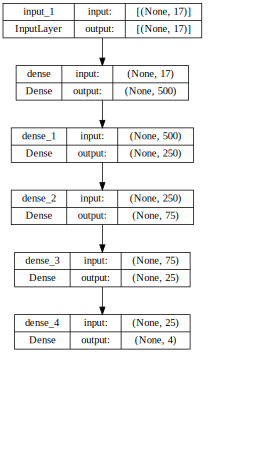

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

## Training

In [14]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [15]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

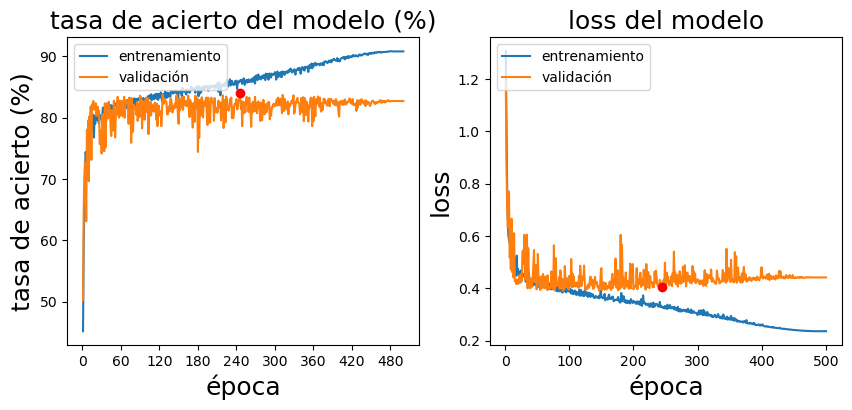

In [16]:
from keras.callbacks import ModelCheckpoint
from IPython.display import SVG, display, clear_output

start = time.perf_counter()
results=pd.DataFrame()
modelpath="model_current_best.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(n_epochs):

    history = model.fit(x_train, t_train, 
                    batch_size = batch_size, 
                    epochs = 1,
                    callbacks=callbacks_list,
                    verbose = 1, 
                    shuffle = True,
                    validation_data = (x_dev, t_dev))
   
    if history.history['val_categorical_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_categorical_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_categorical_accuracy'][-1]
    
    acum_tr_acc.append(history.history['categorical_accuracy'][0])
    acum_val_acc.append(history.history['val_categorical_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

    
    results=pd.concat([results,pd.DataFrame(history.history)])
    results_temp = pd.DataFrame(history.history)

In [17]:
results=results.reset_index(drop=True)

In [18]:
from keras.models import load_model
model = load_model(modelpath)

In [19]:
print ("Time: ", time.perf_counter() - start, "seconds")

human_error = 10
train_error = 100 - (results.categorical_accuracy.values[-1:][0] * 100)
test_error = 100 - (results.val_categorical_accuracy.values[-1:][0] * 100)

print ("Training Set Error: ", train_error, "%")
print ("Development Set Test Error: ", test_error, "%")
print ("Bias: ", train_error - human_error, "%")
print ("Variance: ", test_error - train_error, "%")

Time:  266.3563459049983 seconds
Training Set Error:  9.211444854736328 %
Development Set Test Error:  17.296963930130005 %
Bias:  -0.7885551452636719 %
Variance:  8.085519075393677 %


In [20]:
results.head()

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,1.305741,0.451811,1.188771,0.502790
1,1.057001,0.591455,0.903134,0.647861
2,0.819740,0.654416,0.728227,0.698078
3,0.677884,0.713732,0.633465,0.727216
4,0.601617,0.743971,0.648734,0.710477


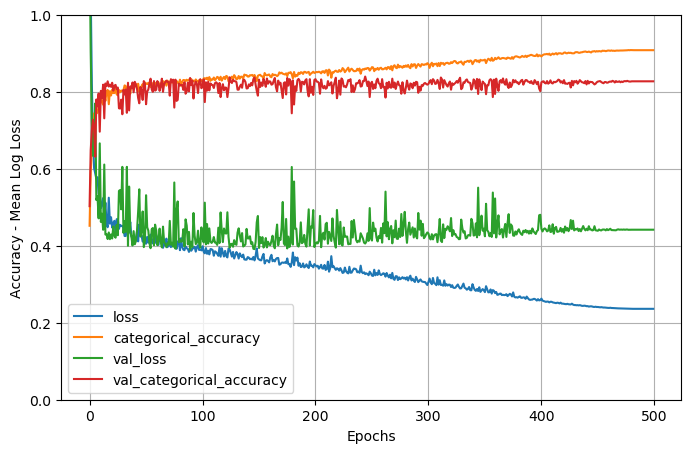

In [21]:
results.plot(figsize = (8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1)
plt.show()

In [22]:
dev_predictions=model.predict(x_dev).round(2)
dev_predictions[:20]

51/51 [==============================] - 0s 1ms/step


array([[0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.03, 0.71, 0.25],
       [0.  , 0.06, 0.89, 0.05],
       [0.01, 0.88, 0.11, 0.  ],
       [0.09, 0.9 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.75, 0.25, 0.  , 0.  ],
       [0.04, 0.9 , 0.05, 0.  ],
       [0.  , 0.  , 0.1 , 0.9 ],
       [0.04, 0.96, 0.  , 0.  ],
       [0.  , 0.88, 0.12, 0.  ],
       [0.04, 0.7 , 0.26, 0.  ],
       [0.03, 0.84, 0.13, 0.  ],
       [0.  , 0.  , 0.47, 0.53],
       [0.16, 0.84, 0.  , 0.  ],
       [0.77, 0.23, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.05, 0.94, 0.02],
       [0.  , 0.  , 0.07, 0.93],
       [0.03, 0.74, 0.23, 0.  ]], dtype=float32)

In [23]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

In [24]:
t_dev[:20] #target classes

,"Poor:[46.0, 62.0]","Interm:[63.0, 66.0]","Good:[67.0, 71.0]","Excel:[72.0, 94.0]"
5668,0.0,0.0,0.0,1.0
12423,0.0,0.0,1.0,0.0
8564,0.0,1.0,0.0,0.0
9360,0.0,1.0,0.0,0.0
10101,0.0,1.0,0.0,0.0
6675,0.0,0.0,0.0,1.0
7926,1.0,0.0,0.0,0.0
7782,0.0,1.0,0.0,0.0
4865,0.0,0.0,0.0,1.0
1934,0.0,1.0,0.0,0.0


In [25]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(np.array(t_dev),1))
print (dev_correct_predictions[:30])

[ True  True False  True  True  True  True  True  True  True  True False
  True False  True False  True  True  True False False False  True  True
  True False  True  True  True  True]


In [26]:
from collections import Counter
Counter (dev_correct_predictions)

Counter({True: 1353, False: 260})

## Final Test

In [27]:
final_results = model.evaluate(x_final_test, t_final_test)

print ("Final Test Accuracy: ", final_results[1] * 100, "%")

51/51 [==============================] - 0s 1ms/step - loss: 0.4765 - categorical_accuracy: 0.7947
Final Test Accuracy:  79.46650385856628 %
